In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/rossmann-store-sales.zip'  # Change this to your actual path
extract_folder_path = '/content/data/'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

# Verify extraction
os.listdir(extract_folder_path)


['sample_submission.csv', 'test.csv', 'store.csv', 'train.csv']

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the data
train_df = pd.read_csv('/content/data/train.csv')
test_df = pd.read_csv('/content/data/test.csv')
store_df = pd.read_csv('/content/data/store.csv')

# Check the data
logging.info("Training data loaded: %s rows, %s columns", train_df.shape[0], train_df.shape[1])
logging.info("Test data loaded: %s rows, %s columns", test_df.shape[0], test_df.shape[1])
logging.info("Store data loaded: %s rows, %s columns", store_df.shape[0], store_df.shape[1])

# Preview the first few rows of each dataset
train_df.head(), test_df.head(), store_df.head()


<ipython-input-4-5eb65969b908>:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/content/data/train.csv')


(   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
 0      1          5  2015-07-31   5263        555     1      1            0   
 1      2          5  2015-07-31   6064        625     1      1            0   
 2      3          5  2015-07-31   8314        821     1      1            0   
 3      4          5  2015-07-31  13995       1498     1      1            0   
 4      5          5  2015-07-31   4822        559     1      1            0   
 
    SchoolHoliday  
 0              1  
 1              1  
 2              1  
 3              1  
 4              1  ,
    Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
 0   1      1          4  2015-09-17   1.0      1            0              0
 1   2      3          4  2015-09-17   1.0      1            0              0
 2   3      7          4  2015-09-17   1.0      1            0              0
 3   4      8          4  2015-09-17   1.0      1            0              0
 4   5 

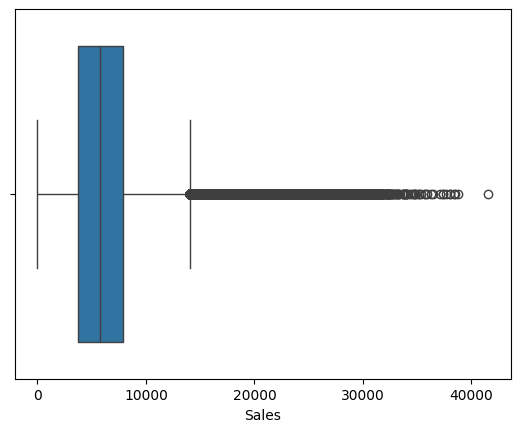

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
# Check for missing values in each dataframe
logging.info("Missing values in train data:\n%s", train_df.isnull().sum())
logging.info("Missing values in test data:\n%s", test_df.isnull().sum())
logging.info("Missing values in store data:\n%s", store_df.isnull().sum())

# Merge train data with store data for analysis
train_merged = pd.merge(train_df, store_df, on='Store', how='left')

# Fill missing values where necessary (for instance, filling with 0 for numeric columns)
train_merged['Promo'] = train_merged['Promo'].fillna(0)

# Check for outliers (using Z-score or boxplots)
# Example: Checking outliers in 'Sales'
sns.boxplot(x=train_merged['Sales'])
plt.show()

# Handle outliers (removing extreme values)
train_merged = train_merged[train_merged['Sales'] < 50000]

# After cleaning, check the first few rows
train_merged.head()


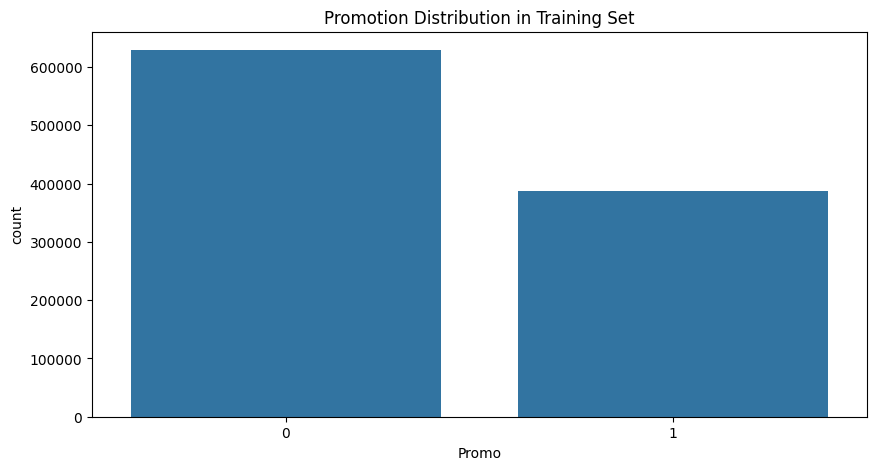

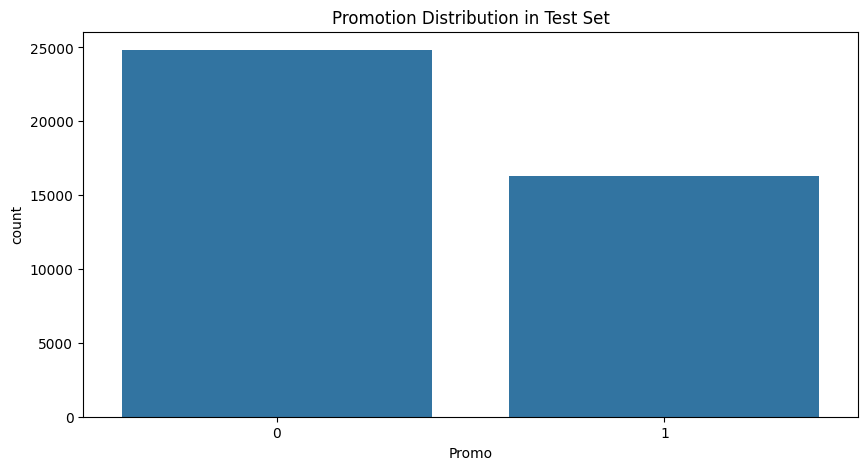

In [6]:
# Check if promotions are distributed similarly between train and test sets
train_promos = train_df['Promo'].value_counts(normalize=True)
test_promos = test_df['Promo'].value_counts(normalize=True)

logging.info("Promotion distribution in training set:\n%s", train_promos)
logging.info("Promotion distribution in test set:\n%s", test_promos)

# Visualizing the distributions
plt.figure(figsize=(10, 5))
sns.countplot(x='Promo', data=train_df)
plt.title('Promotion Distribution in Training Set')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='Promo', data=test_df)
plt.title('Promotion Distribution in Test Set')
plt.show()


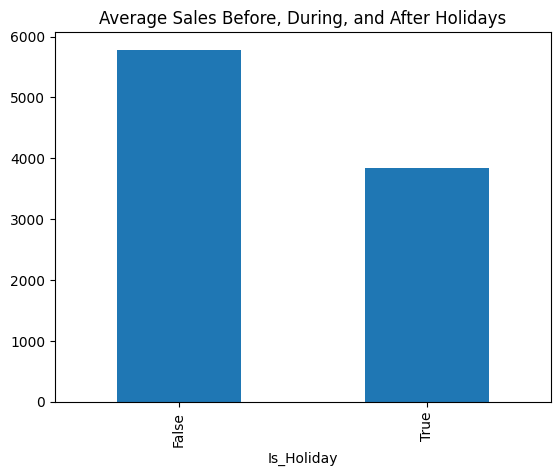

In [7]:
# Assuming 'Date' column is present in the train data and is in datetime format
train_merged['Date'] = pd.to_datetime(train_merged['Date'])
train_merged['Month'] = train_merged['Date'].dt.month
train_merged['Day'] = train_merged['Date'].dt.day
train_merged['Year'] = train_merged['Date'].dt.year

# Check holidays behavior (e.g., Christmas and Easter)
holidays = ['12-25', '04-01']  # Example: Christmas and Easter

# Create a column to mark holidays
train_merged['Is_Holiday'] = train_merged['Date'].dt.strftime('%m-%d').isin(holidays)

# Visualize sales behavior before, during, and after holidays
holiday_sales = train_merged.groupby('Is_Holiday')['Sales'].mean()

logging.info("Holiday Sales: %s", holiday_sales)

holiday_sales.plot(kind='bar', title='Average Sales Before, During, and After Holidays')
plt.show()


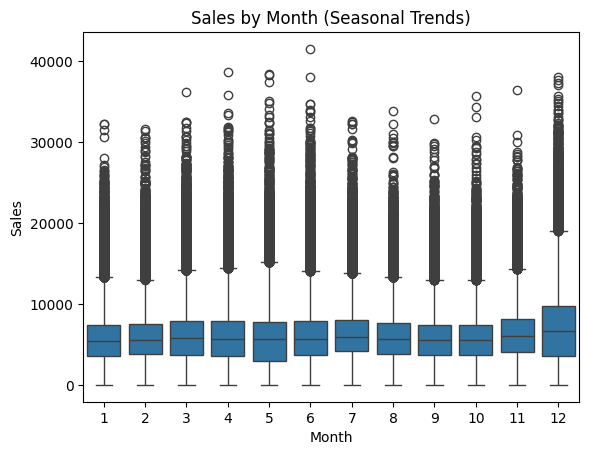

In [8]:
# Analyzing seasonal sales behavior (e.g., around Christmas, Easter)
sns.boxplot(x='Month', y='Sales', data=train_merged)
plt.title('Sales by Month (Seasonal Trends)')
plt.show()


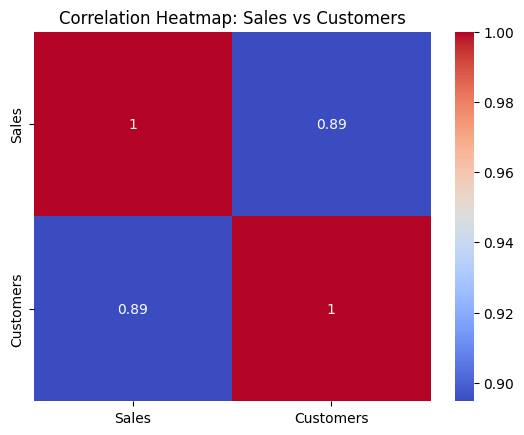

In [9]:
# Check correlation between sales and customers
correlation = train_merged[['Sales', 'Customers']].corr()
logging.info("Correlation between Sales and Customers: %s", correlation)

# Visualizing the correlation
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Sales vs Customers')
plt.show()


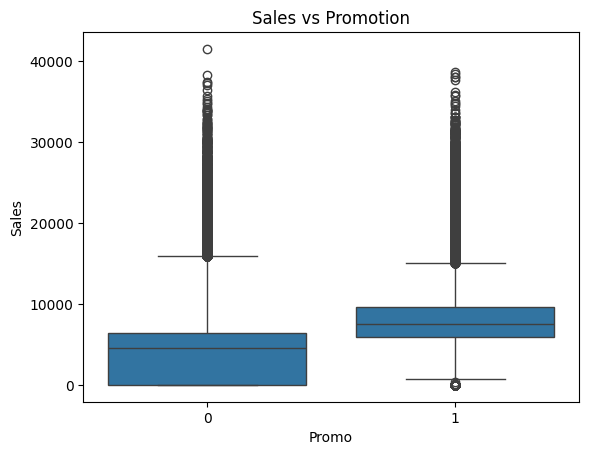

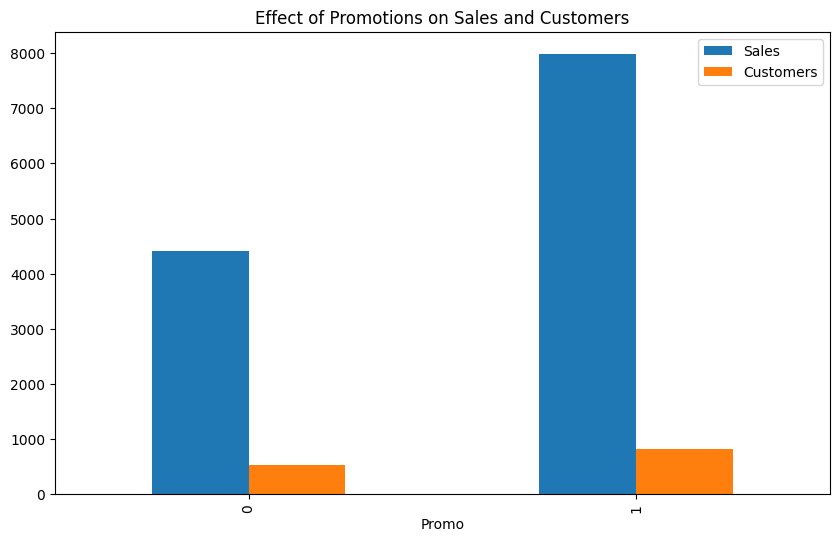

In [10]:
# Visualize sales vs promo status
sns.boxplot(x='Promo', y='Sales', data=train_merged)
plt.title('Sales vs Promotion')
plt.show()

# Does promo attract more customers?
promo_customer_corr = train_merged.groupby('Promo')[['Sales', 'Customers']].mean()
logging.info("Average sales and customers by Promo status:\n%s", promo_customer_corr)

# Plot the comparison
promo_customer_corr.plot(kind='bar', figsize=(10, 6))
plt.title('Effect of Promotions on Sales and Customers')
plt.show()


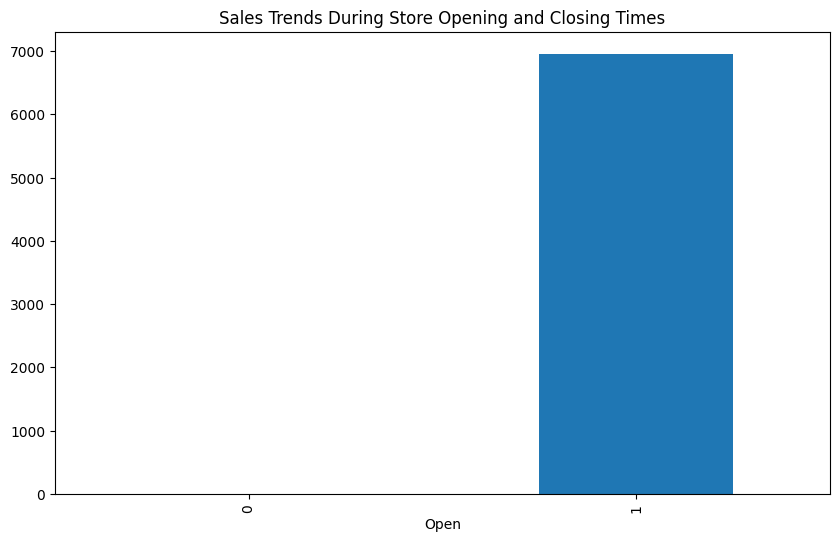

In [11]:
# Assuming 'Open' is a column indicating whether the store was open or closed
store_opening_time = train_merged.groupby('Open')['Sales'].mean()

logging.info("Sales trends based on store opening time:\n%s", store_opening_time)

store_opening_time.plot(kind='bar', figsize=(10, 6))
plt.title('Sales Trends During Store Opening and Closing Times')
plt.show()


In [12]:
logging.info("EDA completed successfully!")
